# Disaster Prediction Using Tweets
**Participants**: Seong Chan Cho, Ael Lee, Yeo Myeong Yoon 

# Goals and Rationale

Twitter has been widely used as a medium to communicate disasters. Throughout this project, we aimed to train a natural-language classifier that classifies tweets as disasters or non-disasters. For achieving this purpose, we utilized the pre-trained models from [Hugging Face](https://huggingface.co/) and fine-tuned them to better suit our task. 

We decided to use pre-trained transformers models not only because of their convenience, but also because of the variety of models it provided. As we will see soon, the pre-trained model that we used was already trained on twitter texts, meaning that it already had knowledge about how tweets differ from, for example, a journal report. This task is also part of a [Kaggle competition](https://www.kaggle.com/competitions/nlp-getting-started), in which we are also participating. 

# Importing Data/Libraries

In [ ]:
# import necessary libraries
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
import pandas as pd
import numpy as np 
import regex as re
import torch
import string

import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import STOPWORDS
from nltk import FreqDist, word_tokenize
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB

After importing most of the necessary libraries for starting the project, we started with reading in the [data](https://www.kaggle.com/competitions/nlp-getting-started/data) provided by the competition. 

In [ ]:
# import Data "Disaster Tweets"
raw_train_df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
raw_test_df = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

We used pandas to read and store the training and testing data sets. The training set will first be used to train the model on classifying each tweet as a disaster or non-disaster and later to analyze the model's performance. The test data set is typically used for model evaluation. However, given our circumstances in participating in a competition, we could not do so.

In [ ]:
print(f"The training data has {len(raw_train_df)} rows; the test data has {len(raw_test_df)} rows.")

In [ ]:
raw_train_df.head()

The training dataset consisted of 5 columns: `id`, `keyword`, `location`, `text`, and `target`. 
* `id`: The `id` indicates the unique rows
* `keyword`: The `keyword` contains the keyword in the `text` column (may be blank)
* `location`: The location where the tweet was written (may be blank)
* `text`: The raw tweet
* `target`: Whether the tweet indicated a disaster or not; 1 means disaster, 0 means a non-disaster

In [ ]:
raw_test_df.head()

The test dataset consisted of 4 columns: `id`, `keyword`, `location`, and `text`. 
* `id` (int): The `id` indicates the unique rows
* `keyword`: The `keyword` contains the keyword in the `text` column (may be blank)
* `location`: The location where the tweet was written (may be blank)
* `text`: The raw tweet

Because the test set did not have the `target` column, we decided to approach this problem with a train-valid set split, using 80% of `raw_training_df` as the training set and the remaining 20% for the validation set. To make things simple, we separated the model training script to [another notebook](https://www.kaggle.com/code/aellee/twitter-model-training-script/notebook). The rest of this notebook will focus on data exploration with visualizations, model utilization and comparison, and an analysis of the model on the test dataset. 

# Data Preprocessing

Before getting started on this project, we reviewed several code from other competition participants. Most, if not all, participants used a data preprocessing function to clean the raw Twitter text. Some common examples included: 
* Removing URLs
* Removing emojis
* Removing punctuations
* Removing extra spaces and newlines

However, we noticed that participants were using different base models for the competition. Some people used other transformers models, such as BERT and RoBERTa, while others made a PyTorch/TensorFlow model from scratch. Especially those who used pre-trained models used models that were trained on natural language sentences, which differ from tweets. Such heavy preprocessing scripts may have been necessary for models that were not trained on tweets, but given that our model was trained tweet data, we decided to reduce the amount of data preprocessing significantly. 

The model we fine-tuned was a [RoBERTa-based sentiment classifier](https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment). This model was trained on the [`tweet-eval` dataset](https://huggingface.co/datasets/tweet_eval), which contained raw twitter data. 

In [ ]:
from datasets import load_dataset

dataset = load_dataset("tweet_eval", "sentiment")
dataset['train']['text'][0:10]

Looking through the pre-training dataset, we noticed two features: 
* The data did not contain URLs
* The data replaced all mentions with @user, making them anonymous

To accomodate for the features of the dataset that was used to train our pre-trained model, we decided to come up with our own preprocesing function, which got rid of URLs and replaced @ mentions with `@user`. The code can be seen below: 

In [ ]:
# use regex to clean the data
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def replace_mentions(text):
    mention = re.compile(r'@([A-Za-z0-9_\.]+)')
    text = mention.sub(r'@user',text)
    return text

In [ ]:
# return clean text after removing url and replacing mentions with @user
def clean_text(text):
    text = remove_url(text)
    text = replace_mentions(text)
    return text

# Visualization of the Dataset

In this section, hashtags, mentions, and links are extracted from each text to create a new column in the data for each category. The purpose of extracting and exhibiting the information is to help visualize the content of the text and predict if hashtags, mentions, and links are signs of disasters. The following code can be found in [this notebook](https://www.kaggle.com/code/nadiaoukrich/step-by-step-explanation-nlp-tweets-disaster).

In [ ]:
def find_hashtags(tweet):  
    return " ".join([match.group(0)[1:] for match in re.finditer(r"#\w+", tweet)]) or 'no'

def find_mentions(tweet):
    return " ".join([match.group(0)[1:] for match in re.finditer(r"@\w+", tweet)]) or 'no'

def find_links(tweet):
    return " ".join([match.group(0)[:] for match in re.finditer(r"https?://\S+", tweet)]) or 'no'

In [ ]:
def compute_new_columns(example): 
    ct = clean_text(example['text'])
    ht = find_hashtags(example['text'])
    m = find_mentions(example['text'])
    l = find_links(example['text'])
    
    return {
        "clean_text": ct,
        "hashtags": ht,
        "mentions": m,
        "links": l
    }

In [ ]:
# extract hashtags, mentions, and links from each tweet in the DataFrame
# add new columns to our dataset
def process_text(df):    
    df['clean_text'] = df['text'].apply(lambda x: clean_text(x))
    df['hashtags'] = df['text'].apply(lambda x: find_hashtags(x))
    df['mentions'] = df['text'].apply(lambda x: find_mentions(x))
    df['links'] = df['text'].apply(lambda x: find_links(x))

    return df

train_df = process_text(raw_train_df)
train_df.head()

4 new columns are added to the train dataset: `clean_text`, `hashtags`, `mentions`, and `links`. 
* `clean_text`: The new text after the original text has been cleaned
* `hashtags`: The hashtags (#) in the tweets <hashtag name **or** indication of no hashtag (no)>
* `mentions`: The mentions (@) in the tweets <mentioned name **or** indication of no mentions (no)>
* `links`: The links in the tweets <link url **or** indication of no links (no)>

To analayze the **patterns and relationships within data**, we will be using graphs to visualize the tweet disaster dataset.

Through Visualizations, we can identify: 

* **Trends**: By creating visualizations of the tweet disaster dataset, we can identify trends in the data over time. For example, we might notice an increase in the frequency of tweets about a particular disaster event, or a shift in the sentiment of tweets as the event progresses. These trends can help us understand how the public is reacting to the event, and how sentiment is changing over time.

* **Frequency**: Visualizations can also help us identify the frequency of certain keywords or phrases in the tweet dataset. This can be useful for identifying which topics or issues are most important to the public, and can help us prioritize our response to the disaster event. For example, if we notice that certain keywords are trending in tweets related to the disaster, we may want to focus our resources on addressing those issues.

* **Outliers and Anomalies**: Visualizations can help us identify outliers and anomalies in the data, which could be important for understanding unusual events or emergencies. For example, if we notice a sudden spike in the number of tweets about a particular issue, it could indicate a new development in the disaster event that we were previously unaware of. By identifying these outliers and anomalies, we can investigate further and potentially take action to address the issue.

* **Discovering new insights**: Visualizing data can reveal insights that may not be immediately apparent from just looking at raw data or tables.

* **Key Findings**: Visualizations can help us communicate the key findings from the data in a clear and concise way. By presenting our insights in a visual format, we can make it easier for others to understand and act on our findings. For example, we might create a chart or graph that shows the frequency of tweets related to different aspects of the disaster event, or a map that highlights the areas that have been most heavily impacted. These visualizations can help us communicate our findings to stakeholders and decision-makers, and can be an important tool for driving action and change.

Most importantly, through data visualizations, we can understand data more comprehensively and help us make better decisions and take more effective action in response to the disaster event.

The following are the countplots to show the most frequently appeared hashtags, mentions, and links in the training data. The foundation of the [code](https://www.kaggle.com/code/nadiaoukrich/step-by-step-explanation-nlp-tweets-disaster) used in this section comes from another participant of this kaggle competition.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# frequency of target variables: 0 or 1
sns.countplot(x='target', data=train_df, palette='Pastel1')
plt.title('Frequency of Target');

print(train_df['target'].value_counts())

Each tweet in the data set is indicated as the target of either 0 or 1: 
* **0 for non-disaster**
* **1 for real disaster**

The graph above represents the frequency of each target that appears in the training data of 7613 tweet texts. 
Within the training data, 4342 of the tweets are categorized as a non-disaster, while 3271 of the texts carry the news of a real disaster. 

In [ ]:
# customize palette for the color combination of the plots
palette_1 = sns.color_palette('pastel', n_colors=2)
palette_2 = sns.color_palette('Pastel1', n_colors=2)
palette_3 = sns.color_palette('Pastel2', n_colors=2)

### Keywords

In [ ]:
# show the frequency of the 20 most common keywords
plt.figure(figsize=(10,4))
sns.countplot(y=train_df.keyword, order=train_df.keyword.value_counts().iloc[:20].index, palette=palette_1)
plt.title('Top 20 keywords')
plt.show()

The training data contains a keyword column that stores one significant word of the given tweet. Among the texts that do have a keyword, *fatalities* is the most frequently appeared keyword, followed by *deluge* and *armageddon*. Alongwith the top three keywords, *sinking*, *damage*, *harm*, and *body bags* also appear as the keyword over 40 times in the dataset of 7613 tweets. To compare the top 20 keywords from non-disaster and disaster tweets, the following two graphs were drawn: 

In [ ]:
t0 = train_df[train_df['target'] == 0]
t1 = train_df[train_df['target'] == 1]
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(25,6))

# draw the first plot of top keywords from non-disaster data
sns.countplot(y=t0.keyword, order=t0.keyword.value_counts().iloc[:20].index, palette=palette_2, ax=ax1)
ax1.set_title('Top 20 keywords for non-disaster')

# draw the second plot of top keywords from disaster data
sns.countplot(y=t1.keyword, order=t1.keyword.value_counts().iloc[:20].index, palette=palette_3, ax=ax2)
ax2.set_title('Top 20 keywords for disaster')

When observing two plots, the top 20 keywords in both categories appear in an approximately similar level of frequnecy. The keywords from the tweets indicated as a disaster contain more nouns that are specific to a certain type of a disaster: *derailment, wreckage, outbreak, debris, oil spill, typhoon, suicide bombing, nuclear disaster, earthquake, airplane accident, wildfire, and bridge collapse*. On the other hand, the top keywords from non-disaster tweets include verbs or adjectives that are more general: *wrecked, ruin, deluge, explode, twister, fear, panic, screaming, blaze, crush, sinking, traumatised*. This could be due to the flexibility of the verbs or adjectives that can be used in a more general context, unlike a description of a real disaster for a specific situation.

### Hashtags

In [ ]:
# show the frequency of the 20 most common mentions - exclude the frequency of "no" from the plot
plt.figure(figsize=(10,4))
sns.countplot(y=train_df.hashtags[-(train_df.hashtags == 'no')], order=train_df.hashtags.value_counts().iloc[:20].index, palette=palette_1)
plt.title('Top 20 hashtags')
plt.show()

Hashtags were extracted from the tweets and were stored in a new column, if the text contained any. Over 5000 out of 7613 tweets do not have a hashtag in the text. Among the texts that have a hashtag, the most frequently appeared hashtags were *hot, prebreak, and best* with about 30 times, followed by *GBBO* (The Great British Bake Off) with over 10 times. Other hashtags vary from news (ex. BCC, CNN) to specific religion (Islam) and even entertainment. To compare the top 20 hashtags from non-disaster and disaster tweets, the two plots were drawn separately:

In [ ]:
# draw the first plot of top hashtags from non-disaster data 
plt.figure(figsize=(10,4))
sns.countplot(y=t0.hashtags[-(train_df.hashtags == 'no')], order=t0.hashtags.value_counts().iloc[:20].index, palette=palette_2)
plt.title('Top 20 hashtags for non-disaster')
plt.show()

# draw the second plot of top hashtags from disaster data
plt.figure(figsize=(10,4))
sns.countplot(y=t1.hashtags[-(train_df.hashtags == 'no')], order=t1.hashtags.value_counts().iloc[:20].index, palette=palette_3)
plt.title('Top 20 hashtags for disaster')
plt.show()

The general trend in the non-disaster tweets is mostly centered around entertainment and possibly social issues. The biggest part of the top hashtags include music, such as artists' fandom (*Beyhive* - Beyonce's fandom and *Directioners* - One Direction's fans), genre of music (*Dubstep, TrapMusic, DnB, EDM, Dance*) and streaming service (*SoundCloud*). The top result also shows *GBBO*, a British baking competition show that first came out in 2010. The next most common theme seem to be related to the social (political and religious) issues, noted by *animal rescue, Islam, Iran Deal*, and *LGBT*. Although social injustice is prominent and a sensitive topic, it is not necessarily a disaster that requires an immediate action for physical safety.

The most commonly used hashtags in disaster tweets are weather (*wx*), natural disasters, and locations. While the words related to *news* and its medium (*social news, World News, BBC, CNN*) appear frequently, specific disasters (*sismo, earthquake, ID fire, MH370* - flight # of the flight that disappeared in 2014) and social disasters (*genocide* and *terrorism*) also make up a significant portion. One interesting observation from the data is the frequency of a city or country name: *Hiroshima, Antioch, Manchester, Libya*, an *India*. Both the keywords and the hashtags of disaster tweets include specific disasters or types of disasters that occurred at a particular location.

### Mentions

In [ ]:
# show the frequency of the 20 most common mentions - exclude the frequency of "no" from the plot
plt.figure(figsize=(10,4))
sns.countplot(y=train_df.mentions[-(train_df.mentions == 'no')], order=train_df.mentions.value_counts().iloc[:20].index, palette=palette_1)
plt.title('Top 20 mentions')
plt.show()

Mentions were extracted from the tweets and were stored in a new column, if the text contained any. Over 5000 out of 7613 tweets do not have a mention in the text. Among the texts that have a mention, the most frequently appeared mentions were *YouTube* with about 60 times, followed by *Change* with 9 times. While these two words do not seem to directly indicate the urgency of the news in the tweets, most of the other common mentions are either related to entertainment / arts or news channel. To evaluate if those categories correlate with the the types of tweets, the following plots were drawn:

In [ ]:
# draw the first plot of top mentions from non-disaster data 
plt.figure(figsize=(10,4))
sns.countplot(y=t0.mentions[-(train_df.mentions == 'no')], order=t0.mentions.value_counts().iloc[:20].index, palette=palette_2)
plt.title('Top 20 mentions for non-disaster')
plt.show()

# draw the second plot of top mentions from disaster data
plt.figure(figsize=(10,4))
sns.countplot(y=t1.mentions[-(train_df.mentions == 'no')], order=t1.mentions.value_counts().iloc[:20].index, palette=palette_3)
plt.title('Top 20 mentions for disaster')
plt.show()

*YouTube* and *Change* appear as mentions in both the disaster and non-disaster tweets. A theme that makes up the top mentions of non-disaster tweets is entertainment, such as arts (*DJ Icemoon, Mike Parr, Ariana Grande, Justin Bieber, Ian Hellfire*), show (*Emmerdale*), magazine (*Raynbow Affair*), and fake news (*World Net Daily*). These non-disaster tweets appear to be used as a means to show one's personal taste of music or interest in other entertainments.

Along with *YouTube* and *Change* that do not seem to be significant in determining the urgency of the tweet, the mentions that commonly appear in real disaster tweets also include newspaper / news broadcasting companies or government agencies, including *FoxNews, POTUS, USA Today, Reuters, cnewslive, New York Times, CDC gov, and YahooNews*. This trend of mentioning reliable news channels is a distinctive difference when compared to the top mentions in the nondisaster tweets. When the users utilize tweeter to communicate a real disaster, they would want the news to be from a reliable source but would also want to spread it quickly to raise awareness of the disaster.

# Create Statistics from Texts

This section displays the most common words that are used in the tweet texts and the total counts of those words, excluding the stopwords that do not carry significant meaning to contribute to the text analysis. The foundation of the [code](https://www.kaggle.com/code/nadiaoukrich/step-by-step-explanation-nlp-tweets-disaster) used in this section comes from another participant of this kaggle competition.

In [ ]:
from wordcloud import STOPWORDS
from nltk import FreqDist, word_tokenize

In [ ]:
# create a set of stopwords that will be excluded from text analysis
stopwords = set(STOPWORDS)

In [ ]:
# count the frequency of words excluding stopwords
# store the words (keys) and their frequencies (values) in word_freq
word_freq = FreqDist(w for w in word_tokenize(' '.join(train_df['clean_text']).lower()) if 
                     (w not in stopwords) & (w.isalpha()))

# create a DataFrame from the frequency distribution
word_freq_df = pd.DataFrame.from_dict(word_freq, orient='index', columns=['count'])

# rearrange the words in descending order of the frequency
ordered_words = word_freq_df.sort_values('count',ascending=False)

In [ ]:
# create a bar plot of the top 20 words that appear in the text of the training data
plt.figure(figsize=(8,6))
sns.barplot(x='count', y=ordered_words.head(20).index, data=ordered_words.head(20), color='C4')
plt.title('Top 20 words in all tweets')
plt.show()

The graph shows the 20 most common words used by the tweets in the training data set, regardless of the target value of the text. Although the word does not seem to be meaningful in determining whether the news is a real disaster, the most common word that appears in the texts is *user* with frequency of over 2500. The next three common words, *im*, *amp*, and *will*, also do not seem to convey a sense of disaster / non-disaster. Among the top five common words, *fire* appears to be the only word that could be related to a real disaster.

To distinguish the commonly used words between real disaster and non-disaster tweets, we created two separate charts. The first chart shows top 20 words in disaster tweets, followed by the second chart that shows top 20 words in non-disaster tweets.

In [ ]:
# set the size of the graph
plt.figure(figsize=(14,5))

# the first subplot - disaster
plt.subplot(121)

# create a bar plot of the top 20 words that appear in the text classified as a disaster tweet
word_freq_d = FreqDist(w for w in word_tokenize(' '.join(train_df.loc[train_df.target==1, 'clean_text']).lower()) if
(w not in stopwords) & (w.isalpha()))
word_freq_df_d = pd.DataFrame.from_dict(word_freq_d, orient='index', columns=['count'])
ordered_words_d = word_freq_df_d.sort_values('count',ascending=False)

sns.barplot(x='count', y=ordered_words_d.head(20).index, data=ordered_words_d.head(20), color='C3')
plt.title('Top 20 words in disaster tweets')

# the second subplot - non-disaster
plt.subplot(122)

# create a bar plot of the top 20 words that appear in the text classified as a non-disaster tweet
word_freq_nd = FreqDist(w for w in word_tokenize(' '.join(train_df.loc[train_df.target==0, 'clean_text']).lower()) if
(w not in stopwords) & (w.isalpha()))
word_freq_df_nd = pd.DataFrame.from_dict(word_freq_nd, orient='index', columns=['count'])
ordered_words_nd = word_freq_df_nd.sort_values('count',ascending=False)

sns.barplot(x='count', y=ordered_words_nd.head(20).index, data=ordered_words_nd.head(20), color='C10')
plt.title('Top 20 words in non-disaster tweets')

plt.show()

The top 5 words appear to be significantly different between the two types of tweets, excluding the word *user* that appear as the most common word in both disaster and non-disaster tweets. 

In the real disaster tweets, *fire*, *news*, *amp*, *via*, and *disaster* are used the most, with the word disaster itself being used in the tweets. We can also predict that many of the real disaster tweets in the training data is correlated with the state California and the city Hiroshima. Other words in the data (*suicide*, *police*, *killed*, *storm*, *crash*, *fires*, and *bomb*) reflect natural disasters or other urgent situations that are related to death. In the tweets that are not a real disaster, the top 5 words are *im*, *amp*, *will*, *new*, and *now*, which do not convey urgency without the context. The succeeding words in the list (*one, body, video, got, love, know, back, see, full*, etc) show a similar trend of vagueness and generality except for *emergency*.

Overall, the word choice made by users in thousands of tweets shows a significant difference in the trend between disaster and non-disaster tweets.

# Model Rationales

There were not any pre-trained models that we could use to predict disaster tweets. Therefore, we had to fine-tune existing classification models on the [data we obtained from the competition.](https://www.kaggle.com/competitions/nlp-getting-started/data). For the purpose of comparison, we decided to fine-tune two different classification models and compare their performances on the testing set. 

To make things simple, we created [a separate notebook](https://www.kaggle.com/code/aellee/twitter-model-training-script/notebook) for training the models. They can be viewed through the link provided.

We tried to train was the `cardiffnlp/twitter-roberta-base-sentiment` model, which was trained to analyze sentiments on tweets from the [`tweet-eval` dataset](https://huggingface.co/datasets/tweet_eval). Given inputs, the model labels sequeces as 0, 1, or 2, from negative, neutral, to positive. 

### Fine-tuning

To make the pre-trained model behave so that it performed the task we wanted it to accomplish, we had to go through a fine-tuning process with the disaster tweet data of our own. Prior to makng decisions on data preprocessing, we referred to multiple notebooks that participated in the same competition, and noticed that many of them heavily preprocessed the data by getting rid of links, duplicated words, extra punctuations, emojis, etc. However, the data used for the pre-trained model included hashtags, emojis, and @ mentions replaced with `@user`. Curious of what difference it would make for the model to be trained on two different texts, we decided to train two models. 

We have two different models, in which the only difference between those two are in the kind of data they were fine-tuned on: 
* The "Raw" Model: This model was fine-tuned on the raw tweet texts provided by the competition
* The "Preprocessed" Model: This model was fined-tuned on tweets that were preprocessed to get rid of https:// links and turn all @ mentions into `@user`

Both models were fine-tuned versions of the [cardiffnlp/twitter-roberta-base-sentiment](https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment) model. They were trained with the same hyperparameters, using the same AdamW optimizer with 20% of the training spent on warmup steps. The charts below show the training loss, evaluation loss, and the overall training loss of the training sessions. 

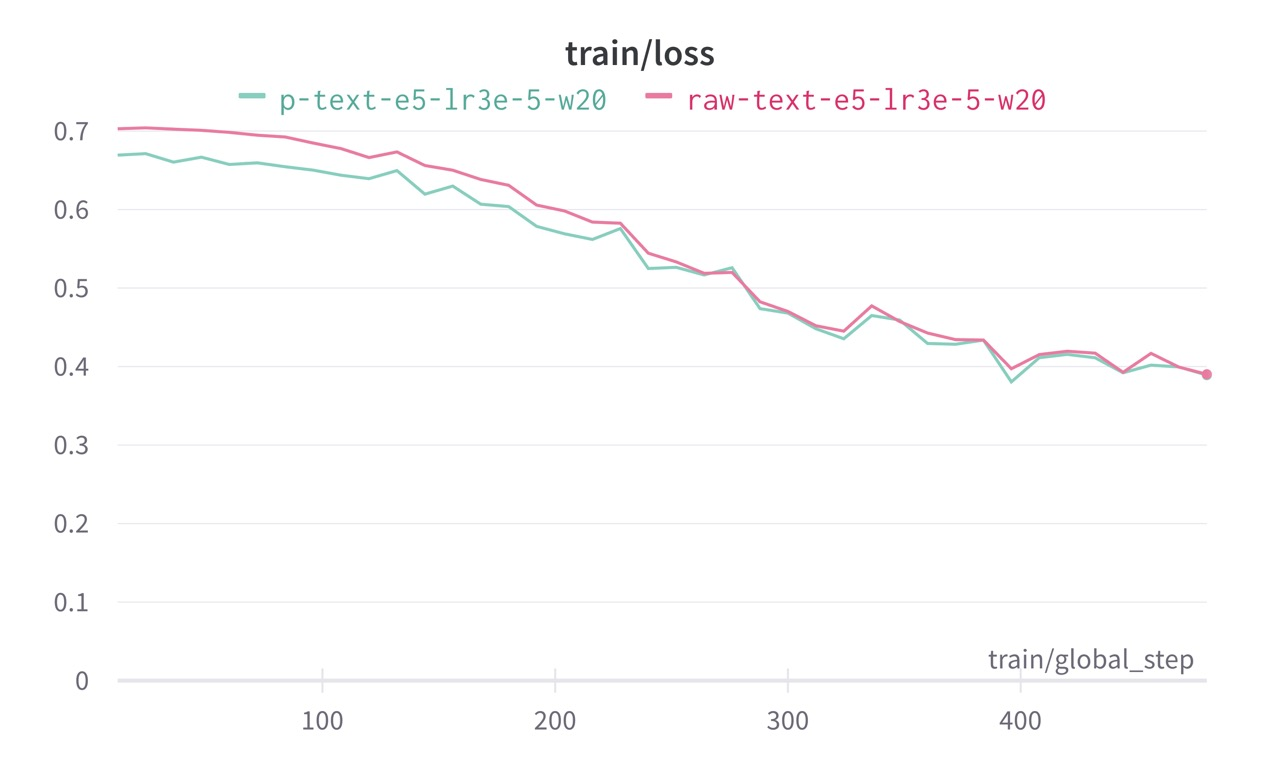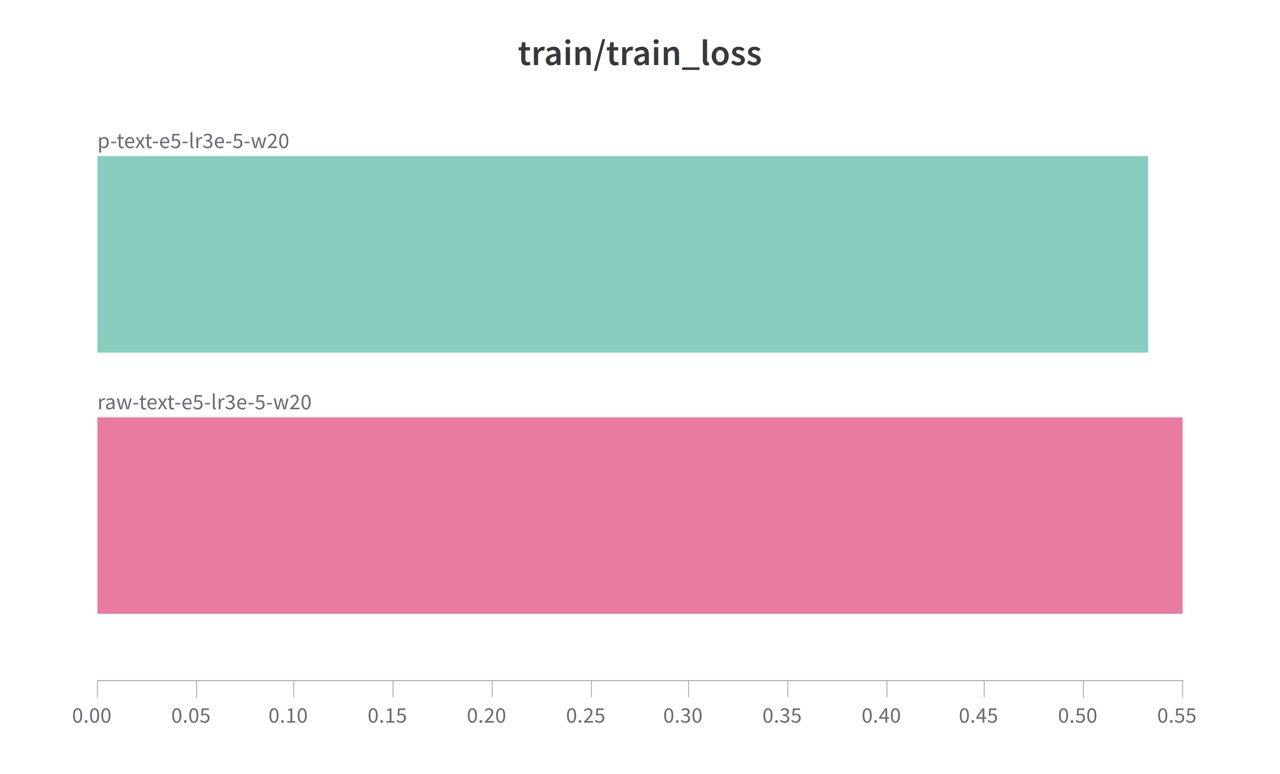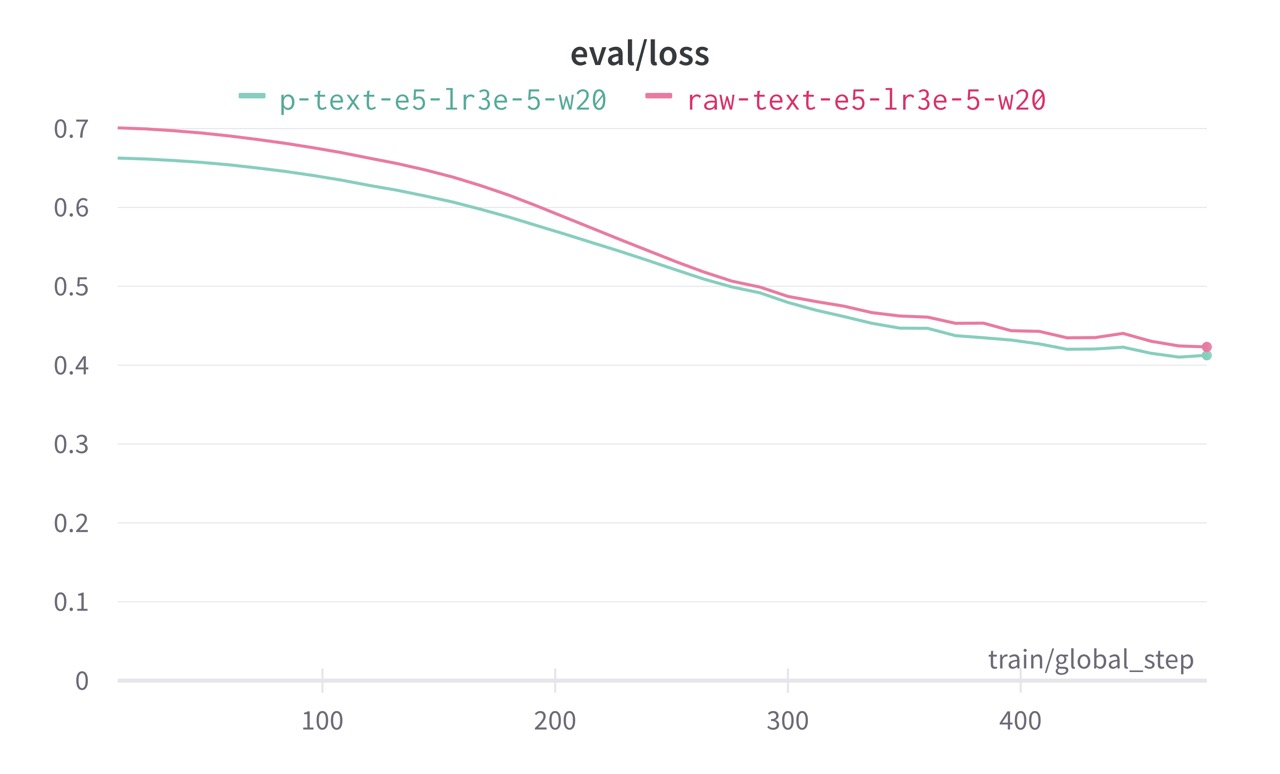

From looking at the graphs above, we observed that the fine-tuned model on preprocessed text had a slightly lower training and evaluation loss than the model fine-tuned on raw text data. The final losses are shown in the table below: 

In [ ]:
df = pd.DataFrame({'Raw Text': [0.5501, 0.3901, 0.4231], 'Processed Text': [0.5326, 0.3892, 0.4125]},
                  index=['train/train_loss', 'train/loss', 'eval/loss'])

# apply a style to the DataFrame
def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: #F1A5A8' if v else '' for v in is_max]

df.style.apply(highlight_max, axis=1)

## Using the Transformers Model

For using the model, we used the [`pipeline` function](https://huggingface.co/docs/transformers/main_classes/pipelines#pipelines) provided by Hugging Face. It provides a simple API to using models that are uploaded to the Hub. 

In [ ]:
from transformers import pipeline

In [ ]:
# define the model checkpoints
raw_text_model = "aellxx/raw_disaster_tweets"
proc_test_model = "aellxx/preprocessed_disaster_tweets"

In [ ]:
# load the tokenizers
r_tokenizer = AutoTokenizer.from_pretrained(raw_text_model)
p_tokenizer = AutoTokenizer.from_pretrained(proc_test_model)

In [ ]:
# load the models
r_model = AutoModelForSequenceClassification.from_pretrained(raw_text_model)
p_model = AutoModelForSequenceClassification.from_pretrained(proc_test_model)

In [ ]:
raw_disaster_classifier = pipeline('text-classification', model=r_model, tokenizer=r_tokenizer, device="cuda:0")
proc_disaster_classifier = pipeline('text-classification', model=p_model, tokenizer=p_tokenizer, device="cuda:0")

In [ ]:
# add cleaned text, hashtags, mentions, and links to the test data set
proc_test_df = process_text(raw_test_df)
proc_test_df.head()

In [ ]:
# create a separate list of text before and after pre-processing
raw_text_list = list(raw_test_df.text)
proc_text_list = list(proc_test_df.clean_text)

In [ ]:
# results of label for the text prior to pre-processing
raw_result = raw_disaster_classifier(raw_text_list)

In [ ]:
# results of label for the text after the pre-processing
proc_result = proc_disaster_classifier(proc_text_list)

Now that we have gotten the classification results from the models, we will store their outcomes (`label`) in a pandas series, then aggregate them with the rest of the dataframe. 

In [ ]:
raw_result_series = pd.DataFrame(raw_result).label
proc_result_series = pd.DataFrame(proc_result).label

In [ ]:
# make a copy of proc_test_df for the clarity of naming
full_test_df = proc_test_df

In [ ]:
full_test_df['raw_results'] = raw_result_series
full_test_df['proc_results'] = proc_result_series
full_test_df

In [ ]:
full_test_df.raw_results.value_counts()

In [ ]:
full_test_df.proc_results.value_counts()

We tested the test data using our trained model to determine whether or not the given tweets are a real disaster. 

The text before pre-processing indicates that out of 3263 tweets in the testing data set, 1308 are news about real disasters, while the remaining 1955 tweets are not. After pre-processing the text, 1301 tweets are categorized as a real disaster and 1962 are not. The number only differs by 7 tweets, meaning that 99.79% of the tweets had the same result before and after pre-processing the text.

# Reflection and Analysis

Since the test dataset does not provide the target value, we will be using the training dataset to evaluate the accuracy of results computed by the model. 

In [ ]:
# use the training set to validate the performance of the model on computing the label 
proc_valid_df = raw_train_df

In [ ]:
# create a separate list of text before and after preprocessing
raw_valid_text_list = list(proc_valid_df.text)
proc_valid_text_list = list(proc_valid_df.clean_text)

In [ ]:
# results of label for the text before and after preprocessing
raw_valid_result = raw_disaster_classifier(raw_valid_text_list)
proc_valid_result = proc_disaster_classifier(proc_valid_text_list)

In [ ]:
# put the results of label into a dataframe
raw_valid_result_series = pd.DataFrame(raw_valid_result).label
proc_valid_result_series = pd.DataFrame(proc_valid_result).label

In [ ]:
# change the 'LABEL_0' to 0 and 'LABEL_1' to 1 for comparison with the target value
# add the values to a new column in raw_valid_df
raw_replace = raw_valid_result_series.replace({'LABEL_0': 0, 'LABEL_1': 1})
proc_valid_df['raw_results'] = raw_replace.tolist()
proc_valid_df

In [ ]:
# change the 'LABEL_0' to 0 and 'LABEL_1' to 1 for comparison with the target value
# add the values to a new column in proc_valid_df
proc_replace = proc_valid_result_series.replace({'LABEL_0': 0, 'LABEL_1': 1})
proc_valid_df['proc_results'] = proc_replace.tolist()
proc_valid_df

In [ ]:
# compute the accuracy of the results of the label before preprocessing the text
raw_acc = (proc_valid_df.target==proc_valid_df.raw_results).mean()
print(f"The accuracy of the model trained on raw text data is {(raw_acc * 100):.2f}%")

In [ ]:
# compute the accuracy of the results of the label after preprocessing the text 
proc_acc = (proc_valid_df.target==proc_valid_df.proc_results).mean()
print(f"The accuracy of the model trained on the processed text data is {(proc_acc * 100):.2f}%")

### Analyzing Differences

After seeing how there was not a significant difference between the losses and the accuracies between the two fine-tuned Transformers, we decided to delve deeper into the rows of data in which the two classifiers outputted different values. The code below filters out the mismatching rows and stores their indices so we can retrive those rows from the entire dataframe object. 

In [ ]:
# Retrieve different rows and their indices
result = proc_valid_df[proc_valid_df['raw_results'] != proc_valid_df['proc_results']]
diff_idx = result.index.tolist()
diff_idx[:10]

In [ ]:
diff_df = proc_valid_df.iloc[diff_idx]
diff_text_df = pd.DataFrame({'text': diff_df['text'],
                             'raw_results': diff_df['raw_results'],
                            'clean_text': diff_df['clean_text'],
                            'proc_results': diff_df['proc_results']
                            })

# Don't truncate rows
pd.set_option('display.max_colwidth', None)
# Display results
diff_text_df.head(15)

From our general overview of the dataset, we could see some differences between tweets classified as disasters versus those that were not. For example, looking at the first row, the raw model that had information about the @bbcmtd mention classified the text as a disaster, whereas the processed model that received the anonymous mention did not classify the text as a disaster. However, given the minute differences between loss and accuracy, and the rarity of similar examples, we deduced that there were limitations for us in deciphering general trends between raw and processed texts. 

### Comparison with a Naive-Bayes Classifier

For comparison purposes, we trained an additional Naive-Bayes classifier. Unlike the transformers classifier we fine-tuned, the Naive-Bayes classifier uses a probabilistic algoritm that makes predictions based on the likelihood of each class given the input text. Whereas the transformers models we used "had knowledge of" tweets, the Naive Bayes model does not have such prior "knowledge." Therefore, we thought it would be interesting to observe how the two different models behaved differently. 

The code used for the following NB models is from [this notebook](https://www.kaggle.com/code/mohitsital/0-80777-simplest-model-naive-bayes).

We will first start by "tokenizing" the text by using the [TfidVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). This is a feature extractor that, converts raw text into a matrix of features using a technique called TF-IDF. It uses the idea that words appearing more frequently are more important, while those that do not appear as freqently are not as important. The TfidfVectorizer tool creates this feature matrix by breaking down the text into individual words or groups of words (also known as "n-grams"). The ngram_range parameter specifies the range of n-grams to include in the feature matrix. Because we set our `ngram_range` parameter to `(1, 3)`, our input data will all individual words (unigrams), all pairs of adjacent words (bigrams), and all groups of three adjacent words (trigrams).

In [ ]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,3))

Now that we have defined our tokenizer, we will generate the inputs for the NB classifier. The code below applies the `TfidVectorizer` to both the raw `text` and `clean_text` columns and generates a matrix of TF-IDF features, including all unigrams, bigrams, and trigrams.



In [ ]:
# fit_transform vectorizer to proc_valid_df['text']
tf_idf_raw_mat = tf_idf_vect.fit_transform(proc_valid_df['text'].values) 
# fit_transform vectorizer to proc_valid_df['clean_text']
tf_idf_proc_mat = tf_idf_vect.fit_transform(proc_valid_df['clean_text'].values) 

In [ ]:
print(tf_idf_raw_mat.get_shape())

By looking at the shape of the returned `tf_idf` matrix, we can see that it has 7613 rows (for each row of text) and 172799 features, including all unigrams, bigrams, and trigrams. 

One final step before using our model is to get a list of all the targets to feed into our classifier. To do this, we will simply retrieve the `target` column of our dataset.

In [ ]:
target = proc_valid_df['target']

We can now do a 80/20 split on the dataset and test out how our Naive Bayes classifier (trained on the raw text inputs) performs our main task. 

In [ ]:
x_raw, x_raw_test, y_raw, y_raw_test = train_test_split(tf_idf_raw_mat,target,test_size=0.2,train_size=0.8, random_state=0)
raw_clf = MultinomialNB(alpha=1).fit(x_raw, y_raw)
raw_predicted = raw_clf.predict(x_raw_test)

In [ ]:
raw_accuracy = (848 + 352) / 1523
print(f"The accuracy of the raw NB model is {(raw_accuracy * 100):.2f}%")

The same process applies to the model that was trained on processed texts.

In [ ]:
x_proc, x_proc_test, y_proc, y_proc_test = train_test_split(tf_idf_proc_mat,target,test_size=0.2,train_size=0.8, random_state = 0)
proc_clf = MultinomialNB(alpha=1).fit(x_proc, y_proc)
proc_predicted = proc_clf.predict(x_proc_test)

In [ ]:
proc_accuracy = (847 + 354) / 1523
print(f"The accuracy of the processed NB model is {(proc_accuracy * 100):.2f}%")

In [ ]:
# calculate the percentage difference
percentage_diff = (abs(raw_accuracy - proc_accuracy) / np.mean([raw_accuracy, proc_accuracy])) * 100
print(f"The percentage difference between the accuracies of the raw model and the processed-data model is {percentage_diff:.4f}%")

Unlike what we expected, the performance on the raw text was slightly better than the performance of the processed text classifier. However, we thought the difference between the two measures was not significantly large, for there was only a 0.0833% difference between the accuracies of the two models. 

The table below shows the comparison between accuracies. The first row contains the accuracies for the fine-tuned Transformers and the second row contains the accuracies for the Naive-Bayes models.  

In [ ]:
accuracy_df = pd.DataFrame({'Raw Text': [84.63, 78.79],
                           'Processed Text': [84.06, 78.86]})
accuracy_df

### Model: Limits and Future Directions

We fine-tuned the pre-trained model using Hugging Face's Trainer API, and the API did not provide means of reporting the accuracy as it was training. In addition, the test dataset provided by the Kaggle competition did not contain target values, so we had no way of evaluating the model's performance on new data other than the evaluation loss reported above. Therefore, we had to evaluate the accuracy after the model was trained, on the same training data used for fine-tuning the model. While we believe this itself as a major limitation of our project, it makes sense that the test dataset did not have any labels, for the datasets were provided to serve the purposes of a competition. 

Meanwhile, because the dataset was small we assumed that a larger dataset with more text examples could perhaps help lower the losses and increase the accuracies. Additionally, given the similar losses and accuracies between the raw model and processed model, we began to wonder if there were any other, more significant factors that we would have missed. Considering these limitations, we believe some future directions for this project can include the following: 

1. Trying different data pre-processing methods
2. Implementing a training loop from scratch to report the accuracy as the model trains
3. Increasing the size of the training dataset so the model can learn from more data

### Model: Conclusions

We created two versions of the training set: (1) raw text and (2) text after pre-processing. We applied both to the model we trained and stored the results in the new column of each dataframe. When the results were compared with the given target value, the first set of raw text had an accuracy of 84.63%, while the second set of preprocessed data had a slightly lower accuracy of 84.07%. As indicated by the results of the testing the models, using raw text without removing url and replacing mentions returned a slightly higher accuracy by 0.56%. This computes to about 40 tweets labeled more accurately out of 7613 that were tested. 

In addition, we trained two additional Naive-Bayes classifiers on the raw text data and the processed text data. While we expected the NB models to have a drastically lower accuracy measure than the transformers models, the baseline classifiers had accuracy values of 78.79% and 78.86%, which we thought was a decent value for a probability distribution based model not pre-trained on tweets. 

Although the differences are minute, the results were different from what we anticipated as the texts were pre-processed with the expectation of getting a more accurate results than using the raw text. 

# How might this be useful in real life?

Natural disasters can strike at any time and can have a devastating impact on people's lives, homes and communities. During such disasters, rapid and accurate identification of affected areas is essential for effective response by first responders, media outlets, insurance companies and government agencies. As social media platforms such as Twitter become more popular, more people are using them to report natural disasters and share information about their experiences. This provides an opportunity to use this information to identify natural disasters and their locations in real time.

One way to achieve this is to develop a model that can classify tweets to whether they indicate real-life disasters. The Kaggle Natural Language Processing with Disaster Tweets competition is a great example to solve this problem. The models developed in this competition can classify tweets to identify disasters and--if applicable--their locations to efficiently help people in different circumstances.

**One of the most important advantages of such models is their usefulness in emergency response**. During natural disasters, emergency response teams need to know where to focus their efforts. By analyzing social media posts in real time, responders can identify the most impacted areas and prioritize responses accordingly. For example, you can target areas where many tweets related to floods, fires, hurricanes, or other natural disasters have been reported. This helps save lives by reaching those most in need. Moreover, rescuers may be able to figure out any individuals who have not been saved yet. One example would be the earthquake that happened in Türkiye and northern Syria on February 6, 2023. If people, still buried under debris, were able to upload tweets waiting for rescue, rescuers may be able to find out the location and identify those who still need to be rescued. With this model, it is important to quickly and accurately identify that these tweets are authentic. 

**Another useful application of such models is found in news organizations**. Mass media platforms can use this model to identify tweets related to natural disasters and provide timely and accurate information to their audience. This helps prevent the spread of misinformation and keeps people well informed of what is happening when disasters strike. If news organizations can quickly identify the authenticity of the tweets, they may be able to deliever more accurate and fast information to the audience.
 
**Next would be the insurance companies**. Many people lose their assets due to natural disasters. This puts heavy responsibility and financial burden to companies. Insurers would be able to benefit from a model that could recognize disasters from tweets. Using this model, insurers can quickly identify areas affected by natural disasters and assess damage. They will be able to figure out how much it will cost them in estimate, allowing us to process tweets more efficiently and provide faster assistance for people.

Finally, **government agencies can use this model to identify areas affected by natural disasters and allocate resources accordingly**. This will ensure that assistance goes to those who need it the most and prevent people from being left without basic needs such as food, water and shelter. Again, this model would focus on identifying the authenticity of the tweet to provide people in need with aids in various areas by different organizations in a quicker way.

In conclusion, a model that can detect disasters from tweets would be useful for those who need to quickly and accurately identify areas affected by natural disasters and respond accordingly. Such models can help emergency responders, the press, insurance companies, and government agencies to respond quickly and efficiently to disasters, save lives, and minimize the damages caused by such events.

# Conclusion

The purpose of this project was to build a model that determines whether or not the given tweet indicates a real disaster. The training data set contained id, keyword, location, text, and target of each tweet. We further expanded the data set by extracting hashtags, mentions, and links from the text and appending to new columns. The newly included information was used for data visualization and comparison between disaster and non-disaster tweets. Then the model was fine-tuned with both raw and processed texts from the training set, which resulted in 84.63% and 84.07% accuracy respectively. Then the comparison between raw and processed text was evaluated using the test data, which came out to be 99.79% equivalence between the two types of texts. In terms of general uses, we believe this model can be utilized by news organizations, insurance companies, and government agencies to respond to disasters quickly and accurately.